# Customer Clustering and Product Recommendation
**Project by Naufal Hadi Darmawan  
Github: @NaufalHD12**

This notebook walks you through the process of loading and preprocessing the data, segmenting customers using K-Means clustering, and creating product recommendations using collaborative filtering.

# Data Wrangling and Exploratory Data Analysis

In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [38]:
# load the data
data = pd.read_csv("data.csv", encoding='ISO-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [40]:
# Check for missing values
print(data.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [41]:
# Drop missing CustomerID as these cannot be used in analysis
data_clean = data.dropna(subset=['CustomerID'])

In [42]:
print(data_clean.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [43]:
# Make an explicit copy of the dataframe before modifying it
data_clean = data_clean.copy()

# Now modify the copy using .loc[]
data_clean.loc[:, 'TotalPrice'] = data_clean['UnitPrice'] * data_clean['Quantity']



# Create TotalPrice column (UnitPrice * Quantity)
data_clean.loc[:, 'TotalPrice'] = data_clean['UnitPrice'] * data_clean['Quantity']

# Display basic statistics
data_clean.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,20.401854
std,248.693370,69.315162,1713.600303,427.591718
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,2.000000,1.250000,13953.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [44]:
# 1. Remove rows where Quantity is negative (likely returns or errors)
data_clean = data_clean[data_clean['Quantity'] > 0]

# 2. Remove rows where UnitPrice is zero or negative (invalid prices)
data_clean = data_clean[data_clean['UnitPrice'] > 0]

# 3. Remove extreme outliers in Quantity and UnitPrice using IQR method
# Calculate IQR for Quantity and UnitPrice
Q1_quantity = data_clean['Quantity'].quantile(0.25)
Q3_quantity = data_clean['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

Q1_unitprice = data_clean['UnitPrice'].quantile(0.25)
Q3_unitprice = data_clean['UnitPrice'].quantile(0.75)
IQR_unitprice = Q3_unitprice - Q1_unitprice

# Define outlier thresholds (1.5 times the IQR)
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

lower_bound_unitprice = Q1_unitprice - 1.5 * IQR_unitprice
upper_bound_unitprice = Q3_unitprice + 1.5 * IQR_unitprice

# Remove outliers in Quantity and UnitPrice
data_clean = data_clean[(data_clean['Quantity'] >= lower_bound_quantity) & (data_clean['Quantity'] <= upper_bound_quantity)]
data_clean = data_clean[(data_clean['UnitPrice'] >= lower_bound_unitprice) & (data_clean['UnitPrice'] <= upper_bound_unitprice)]

# 4. Recalculate TotalPrice if necessary
data_clean['TotalPrice'] = data_clean['Quantity'] * data_clean['UnitPrice']

# 5. Check the summary statistics after cleaning
data_clean.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,338151.000000,338151.000000,338151.000000,338151.000000
mean,7.476917,2.192017,15325.967337,12.771994
std,6.770795,1.544770,1710.731279,13.177003
min,1.000000,0.001000,12347.000000,0.001000
25%,2.000000,1.250000,13994.000000,3.800000
50%,6.000000,1.650000,15245.000000,10.080000
75%,12.000000,2.950000,16818.000000,17.400000
max,27.000000,7.500000,18287.000000,178.800000


In [45]:
data_clean.describe(include="all")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
count,338151,338151,338151,338151.000000,338151,338151.000000,338151.000000,338151,338151.000000
unique,16826,3392,3575,NaN,15784,NaN,NaN,37,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,11/14/2011 15:27,NaN,NaN,United Kingdom,NaN
freq,460,1686,1680,NaN,460,NaN,NaN,305129,NaN
mean,NaN,NaN,NaN,7.476917,NaN,2.192017,15325.967337,NaN,12.771994
std,NaN,NaN,NaN,6.770795,NaN,1.544770,1710.731279,NaN,13.177003
min,NaN,NaN,NaN,1.000000,NaN,0.001000,12347.000000,NaN,0.001000
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13994.000000,NaN,3.800000
50%,NaN,NaN,NaN,6.000000,NaN,1.650000,15245.000000,NaN,10.080000
75%,NaN,NaN,NaN,12.000000,NaN,2.950000,16818.000000,NaN,17.400000


# Customer Segmentation Using K-Means Clustering

c:\Users\hadin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


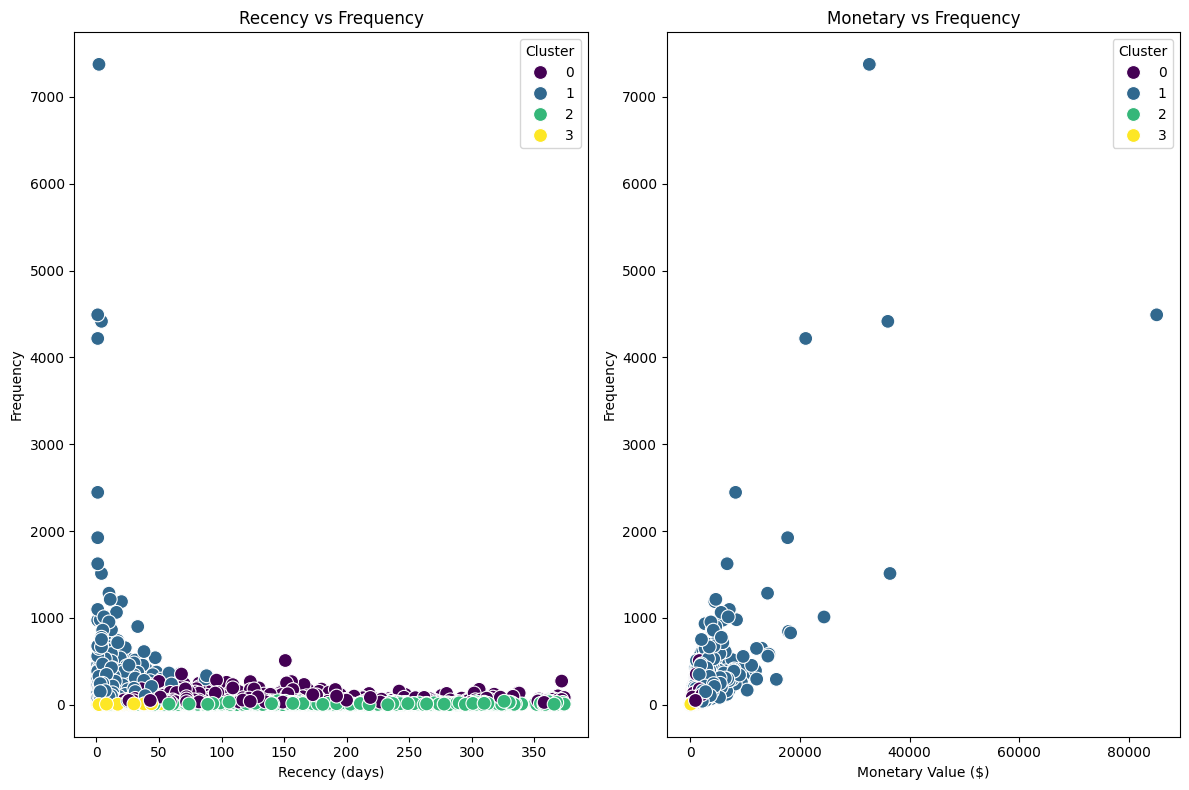

In [53]:
# Ensure InvoiceDate is in datetime format
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'], errors='coerce')

# Now calculate the snapshot date (one day after the last purchase)
snapshot_date = data_clean['InvoiceDate'].max() + pd.DateOffset(1)

# Calculate RFM metrics for each customer
rfm = data_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Rename the columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


# 2. Remove Customers with Zero Monetary Value
rfm = rfm[rfm['Monetary'] > 0]

# 3. Apply Log Transformation to Normalize Skewed Data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log1p(x))

# 4. Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_log)

# 5. Calculate the Mean RFM Values for Each Segment
rfm_cluster = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# 6. Visualize the Segments
plt.figure(figsize=(12, 8))

# Plot for Recency vs Frequency
plt.subplot(1, 2, 1)
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='viridis', s=100)
plt.title('Recency vs Frequency')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')

# Plot for Monetary vs Frequency
plt.subplot(1, 2, 2)
sns.scatterplot(data=rfm, x='Monetary', y='Frequency', hue='Cluster', palette='viridis', s=100)
plt.title('Monetary vs Frequency')
plt.xlabel('Monetary Value ($)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- **Recency vs Frequency:** The left plot shows a clear separation between customers with high recency and low frequency (likely new customers) and those with high frequency and low recency (likely loyal customers). This suggests that customers who have recently made purchases and have a high purchase frequency are more likely to be valuable customers.
- **Monetary vs Frequency:** The right plot reveals that customers with high monetary values and high frequency are concentrated in a specific cluster, indicating they are potentially the most valuable customers. This segment represents customers who not only purchase frequently but also spend significant amounts.

# Product Recommendation Using Collaborative Filtering

In [47]:
# Get unique CustomerIDs
unique_customer_ids = data_clean['CustomerID'].unique()

# Convert to DataFrame for better visualization
customer_id_df = pd.DataFrame(unique_customer_ids, columns=['CustomerID'])

# Display the DataFrame
print(customer_id_df)

      CustomerID
0        17850.0
1        13047.0
2        12583.0
3        14688.0
4        17809.0
...          ...
4186     13436.0
4187     15520.0
4188     13298.0
4189     14569.0
4190     12713.0

[4191 rows x 1 columns]


In [48]:
# Create a pivot table for Collaborative Filtering
customer_product_matrix = data.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)

# Apply Collaborative Filtering using Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
similarity_matrix = cosine_similarity(customer_product_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.index)

def recommend_products(customer_id, similarity_df, customer_product_matrix, data_clean, top_n=5):
    # Get the most similar customers
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).head(top_n).index
    
    # Get products bought by similar customers
    product_recommendations = customer_product_matrix.loc[similar_customers].sum().sort_values(ascending=False)
    
    # Exclude products already bought by the customer
    bought_products = customer_product_matrix.loc[customer_id]
    recommended_products = product_recommendations[bought_products == 0].head(top_n)
    
    # Create a DataFrame to display the recommendations with Description
    recommendations_df = pd.DataFrame(recommended_products).reset_index()
    recommendations_df.columns = ['StockCode', 'Quantity']
    
    # Merge with the data_clean DataFrame to get product descriptions
    recommendations_df = recommendations_df.merge(data_clean[['StockCode', 'Description']].drop_duplicates(), on='StockCode', how='left')
    
    return recommendations_df[['StockCode', 'Description', 'Quantity']]

# Example: Recommend products for CustomerID
recommended_products = recommend_products(17850.0, similarity_df, customer_product_matrix, data_clean, top_n=5)
print(recommended_products)


  StockCode                        Description  Quantity
0     21733   RED HANGING HEART T-LIGHT HOLDER     100.0
1     22789  T-LIGHT HOLDER SWEETHEART HANGING      56.0
2     23327          HANGING CLEAR MINI BOTTLE      48.0
3     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS      48.0
4     23331      DECORATIVE WICKER HEART SMALL      48.0


In [49]:
recommended_products = recommend_products(13436.0, similarity_df, customer_product_matrix, data_clean, top_n=5)
print(recommended_products)

  StockCode                        Description  Quantity
0     23232        WRAP VINTAGE PETALS  DESIGN      50.0
1     23232           WRAP VINTAGE LEAF DESIGN      50.0
2     21499                 BLUE POLKADOT WRAP      50.0
3     21500                PINK POLKADOT WRAP       50.0
4     23546                 WRAP PAISLEY PARK       50.0
5     21922  UNION STRIPE WITH FRINGE  HAMMOCK      48.0


In [50]:
recommended_products = recommend_products(12713.0, similarity_df, customer_product_matrix, data_clean, top_n=5)
print(recommended_products)

  StockCode                          Description  Quantity
0     22967  SET 3 SONG BIRD PAPER EGGS ASSORTED      48.0
1     22957  SET 3 PAPER VINTAGE CHICK PAPER EGG      48.0
2     23295     SET OF 12 MINI LOAF BAKING CASES      24.0
3     22933    BAKING MOULD EASTER EGG MILK CHOC      24.0
4     21086          SET/6 RED SPOTTY PAPER CUPS      24.0


- We create a pivot table where rows are CustomerID and columns are StockCode, with values representing the quantity of each product bought.
- Collaborative Filtering is used by calculating the cosine similarity between customers based on their purchase history.
- A recommendation function is created to suggest products that similar customers have bought, excluding products that the target customer has already purchased.

# Conclusion
Using both K-Means clustering and collaborative filtering for product recommendations offers powerful insights into customer behavior and preferences. This combination allows businesses to:

- Tailor marketing strategies to different customer segments.
- Suggest products that are highly relevant to customers, increasing the likelihood of additional sales.
Overall, this analysis provides valuable tools to improve sales efficiency, customer satisfaction, and ultimately, profitability for B2B clients.